# **Trabajo Práctico Final**: "Clasificación de la osteoartritis de rodilla utilizando imágenes de rayos X"
___________________________________________________________________________
#### *Visión por Computadora II* 
#### *Facultad de Ingeniería de la Universidad de Buenos Aires*
#### *Laboratorio de Sistemas Embebidos*  
#### *Javier Etcheto, Alejandro Le Mehaute y David Canal*
#### *Julio 2025*

 # **1. Resumen**
 ---
Se desarrolló un modelo de clasificación de imágenes de rayos X de rodillas, capaz de distinguir entre rodillas sanas y aquellas con osteoartritis.

Previo al entrenamiento del modelo, se realizó un análisis exploratorio de los datos disponibles con el objetivo de comprender su distribución, calidad y características relevantes. Posteriormente, se procedió a implementar los modelos [nombre del modelo 1] y [nombre del modelo 2], evaluando su desempeño en la tarea de clasificación.

# **2. Introducción**
---
La  osteoporosis es una enfermedad metabólica ósea caracterizada por l adisminución de la masa y la calidad del hueso, lo que incrementa la fragilidad ósea y el riesgo de fracturas. La osteopenia, considerada una etapa previa, también implica una reducció de la densidad mineral ósea, pero en menor grado. La detección temprana de estas condiciones es fundamental para implementar estrategias preventivas y terapéuticas que mejoren la calidad de vida de los pacietes.
El diagnóstico convencional de estas patologías se basa principalmente en técnicas como la absorciometría dual X (DXA), considerada el estándar para medir la densidad mineral ósea. Sin embargo, en muchos entornos clínicos los estudios radiográficos convencionales siguen siendo el primer recurso disponible para la evaluación  de articulaciones, incluida la rodilla.
En este contexto, la interpretación de radiográfias de rodilla requiere un alto nivel de experiencia por parte del personal médico, y esta sujeta a variabilidad interobservador. Además, el volumen creciente de imágenes médicas en los sistemas hospitalarios genera la necesidad de herramientas automatizadas que apoyen el diagnóstico y permitan una clasificación más objetiva y eficiente.
Por ello, se propone el desarrollo de un modelo de visión por computadora basado en aprendizaje profundo que sea capaz de clasificar imágenes de tayos X de rodillas en tres categorría:


*   *Normal.* Sin evidencia de pérdida significativa de masa ósea.
*   *Osteopenia.* Disminución moderada de desidad mineral ósea.
*   *Osteoporosis.* Pérdida severa de masa ósea, con riesgo elevado de fractura.






# **3. Analisis Exploratorio de Datos (EDA)**
---
Antes de aplicar técnicas de procesamiento de imágenes y entrenar modelos, es necesario realizar un Análisis Exploratorio de Datos (EDA, por sus siglas en inglés: Exploratory Data Analysis), con el fin de comprender las características principales del sets de imágenes.

En nuestro caso particular, el EDA se llevó a cabo sobre un conjunto de radiografías de rodilla etiquetadas en las tres categorías mencionadas en la sección anterior: *normal, osteopenia y osteoporosis*.

A continuación, se procedió a importar el conjunto de datos y a realizar una visualización inicial del mismo.

## **3.1 Importación y visualización inicial del dataset**
---

In [25]:
#!pip install -q kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fuyadhasanbhoyan/knee-osteoarthritis-classification-224224")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\javier\.cache\kagglehub\datasets\fuyadhasanbhoyan\knee-osteoarthritis-classification-224224\versions\1


In [26]:
from pathlib import Path
import os

exts = set(p.suffix for p in Path(path).rglob("*") if p.is_file())
print(f"El dataset contiene imagenes con extensiones {' '.join(exts)}")

El dataset contiene imagenes con extensiones .jpeg .JPEG .png .jpg


In [ ]:
from PIL import Image 
from pathlib import Path
import os

clases = ['Normal', 'Osteopenia', 'Osteoporosis']
modos = set()
total_imagen = 0

for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    total_imagen += len([f for f in os.listdir(img_path) if os.path.isfile(f"{img_path}/{f}")])
    for img_name in os.listdir(img_path):
        try:
            img = Image.open(f"{img_path}/{img_name}")
            modos.add(img.mode)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

print(f"Modos encontrados {' y '.join(modos)}")
print(f"El dataset contiene {total_imagen} imagenes")

Modos encontrados RGB y L
El dataset contiene 4179 imagenes


El conjunto de datos está compuesto por 3780 imágenes en formatos PNG y JPG, en modos de color L (escala de grises) y RGB.

Con el objetivo de entrenar un modelo de clasificación, el dataset fue dividido en dos subconjuntos: uno para entrenamiento (training dataset) y otro para validación (validation dataset).

Posteriormente, se realizó una visualización inicial de cinco imágenes representativas de cada categoría dentro del conjunto de entrenamiento, con el fin de verificar la calidad y diversidad de los datos

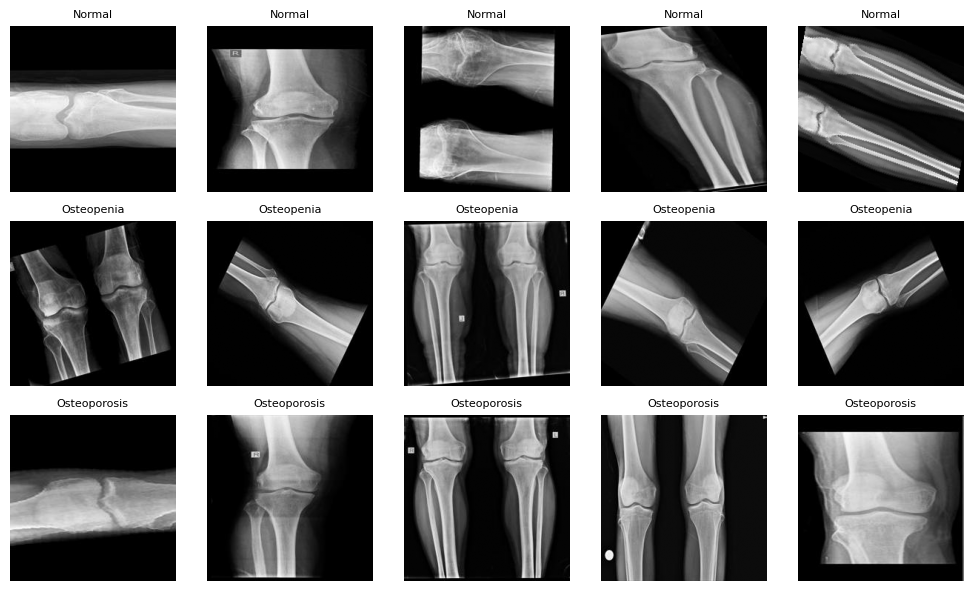

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Visualizo 5 imágenes por clase en una grilla 3x5 para tener una idea general del dataset
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, clase in enumerate(clases):
    dir_clase = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    imgs = random.sample(os.listdir(dir_clase), 5)  # 5 imágenes aleatorias
    for j in range(5):
        img = Image.open(f"{dir_clase}/{imgs[j]}").convert('L')
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"{clase}", fontsize=8)

plt.tight_layout()
plt.show()


Tal como se muestra en la figura anterior, se presentan cinco ejemplos representativos clasificados en tres categorías: Normal, Osteopenia y Osteoporosis. Todas las imágenes están en escala de grises, lo cual es característico de las radiografías. Se observa una considerable variabilidad en la orientación (proyección lateral y anteroposterior) y en el tamaño aparente de las estructuras óseas, lo que resalta la necesidad de aplicar un preprocesamiento consistente.

Desde el punto de vista clínico, las imágenes normales exhiben un mayor contraste y una definición trabecular más marcada (es decir, en el interior del hueso). En los casos de osteopenia, se aprecia una disminución ósea leve a moderada, caracterizada por zonas más opacas debido a la menor refracción de los rayos X en esas áreas. En la osteoporosis, la pérdida de densidad ósea es más pronunciada, lo que da lugar a huesos más transparentes.

Asimismo, se detectan diferencias en la exposición radiográfica y posibles rotaciones en algunas imágenes, lo que refuerza la importancia de aplicar técnicas de normalización de intensidades y estrategias de aumento de datos (data augmentation) para mejorar la robustez del modelo.

## **3.2 Distribución de clases**
---
Contar con un conjunto de datos balanceado es fundamental para evitar que el modelo tienda a sesgarse hacia la clase mayoritaria. Por ello, se procedió a verificar que cada clase contara con un número de imágenes representativo y comparable. El resultado de esta verificación se detalla a continuación:

In [29]:
for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    cantidad = len([f for f in os.listdir(img_path) if os.path.isfile(f"{img_path}/{f}")])
    print(f"{clase}: {cantidad} imágenes")

Normal: 1404 imágenes
Osteopenia: 1260 imágenes
Osteoporosis: 1515 imágenes


De las 3780 radiografías disponibles, las mismas se distribuyen equitativamente entre las tres clases planteadas, esdecir en 1260 imagenes por clases, lo cuál indica que a priori el dataset se encuentra ya balanceado.

## **3.3 Resolución y dimesiones de las imágenes**
---
Basándonos en la visualización realizada en la sección 3.1, se observa que las radiografías provendrían de distintas fuentes. Por este motivo, se procedió a analizar sus dimensiones con el objetivo de verificar si existían diferencias significativas en cuanto a resolución o formato.

In [30]:
img_size = set()

for clase in clases:
    img_path = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    for img_name in os.listdir(img_path):
        try:
            img = Image.open(f"{img_path}/{img_name}")
            img_size.add(img.size)  # (ancho, alto)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

print("Tamaños únicos encontrados:", img_size)

Tamaños únicos encontrados: {(224, 224)}


Las radiografías presentan una resolución homogénea de 224×224 píxeles, lo que, a priori, facilita su integración directa en el pipeline del modelo sin necesidad de realizar un redimensionamiento adicional.

## **3.4 Control de duplicados y estandarización de imágenes**
---
Aunque el conjunto de radiografías presenta una resolución uniforme de 224×224 píxeles, es importante garantizar que no existan imágenes duplicadas, ya que esto podría introducir sesgos durante el entrenamiento del modelo y reducir su capacidad de generalización.

Para asegurar que el data set no contenga imágenes repetidas que puedan inducir a *overfitting*, se realizó un control de duplicados empleando hash perceptual (pHash) con la librería imagehash. Este enfoque permite detectar imágenes visualmente idénticas, incluso si presentan mínimas diferencias en brillo o compresión. El proceso se implementó en dos etapas complementarias:

(1) Verificación preliminar de duplicados por hash único
*   *Conversión a escala de grises*. Cada radiografía fue cargada con la librería Pillow y convertida a escala de grises para homogenizar su representación, evitando que posibles diferencias en formato de color influyan en el cálculo del hash.
*   *Cálculo del hash preceptual (pHash)*. Se utilizó la función imagehash.phash() para generar un hash perceptual de cada imagen. Este tipo de hash está diseñado para capturar las características visuales esenciales de la imagen y es robusto a pequeñas variaciones de contraste, brillo o resolución.
Este paso permitió determinar cuántas imágenes tenían un hash repetido, indicando la existencia de posibles duplicados exactos.

(2) Agrupación y visualización de duplicados
*   *Agrupación por hash*. Se almacenan todas las imágenes en un diccionario indexado por su valor de hash. Aquellos hashes que aparecieron asociados a más de una imagen indicaron posibles duplicados o imágenes prácticamente idénticas.
*   *Filtrado de duplicados.* Se filtraron los grupos de hashes que contenían más de una imagen, obteniendo así un listado de potenciales duplicados.
*   *Inspección visual*. Para verificar los duplicados detectados, se generaron visualizaciones comparativas de los primeros grupos de imágenes con hash idénticos.
De esta forma, se pudo corroborar visualmente si efectivamente existe una relación entre las imágenes repetidas y aquellas que comparten el mismo hash.


In [31]:
#!pip install -q imagehash

## *Primera etapa*
_________________


In [32]:
import imagehash

hashes = set()
duplicados = 0

for clase in clases:
    dir_clase = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    for img_name in os.listdir(dir_clase):
        img = Image.open(f"{dir_clase}/{img_name}").convert('L')
        h = imagehash.phash(img)
        if h in hashes:
            duplicados += 1
        else:
            hashes.add(h)

print(f"Imágenes duplicadas: {duplicados}")

Imágenes duplicadas: 849


## *Segunda etapa*. Verificación de la relación entre hash e imágenes repetidas.
_______________________________

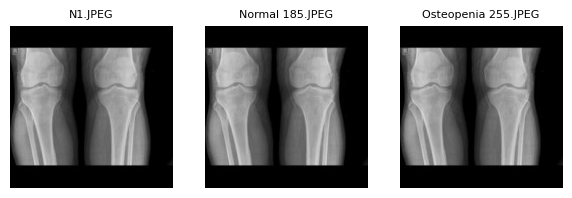

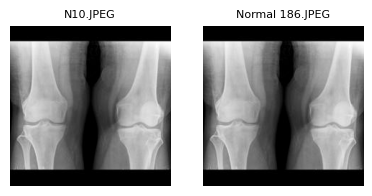

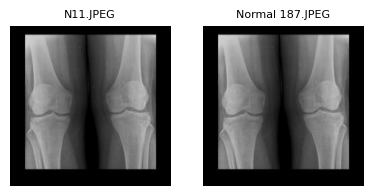

In [33]:
from collections import defaultdict
import imagehash # Importar imagehash
from PIL import Image
import os
import matplotlib.pyplot as plt


# Agrupo imágenes por hash
hash_dict = defaultdict(list)

for clase in clases:
    dir_clase = f"{path}/Knee Osteoarthritis Classification/train/{clase}"
    for img_name in os.listdir(dir_clase):
        try:
            img_path = f"{dir_clase}/{img_name}"
            img = Image.open(img_path).convert('L')
            h = imagehash.phash(img)
            hash_dict[h].append(img_path)
        except Exception as e:
            print(f"Error con {img_name}: {e}")

# Filtro los hashes con más de una imagen (posibles duplicados)
hashes_duplicados = [imgs for imgs in hash_dict.values() if len(imgs) > 1]

# Muestro algunas imagenes repetidas (limitado a los primeros 3 grupos)
# Ya probé con más de 3 grupos y se ve que son siempre iguales
for grupo in hashes_duplicados[:3]:
    fig, axs = plt.subplots(1, len(grupo), figsize=(2 * len(grupo), 2))
    for i, img_path in enumerate(grupo):
        img = Image.open(img_path)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(os.path.basename(img_path), fontsize=8)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

Mediante la visualización presentada anteriormente, se verificó que, a priori, existen imágenes repetidas (849 imagenes), identificadas a través de hashes idénticos: visualmente, dichas imágenes no presentan diferencias.

### **3.4.1 Filtrado y rebalanceo del dataset**
---
Después de la detección de duplicados mediante hash perceptual, se procedió a filtrar y depurar el conjunto de datos para asegurar que cada imagen representara una muestra única, eliminando asi las radiografias repetidas, reduciendo el riesgo de sobreajuste y garantizado una distribución de datos más confiable para el entrenamiento del modelo.

In [34]:
from collections import Counter # Importar Counter
import imagehash # Importar imagehash
from PIL import Image
import os

imagenes_unicas = []
hashes_vistos = set()

def obtener_imagenes_unicas(path_base, clases, subcarpeta='train'):
    imagenes_unicas = []
    hashes_vistos = set()

    for clase in clases:
        dir_clase = f"{path_base}/Knee Osteoarthritis Classification/{subcarpeta}/{clase}"
        for img_name in os.listdir(dir_clase):
            img_path = f"{dir_clase}/{img_name}"
            try:
                img = Image.open(img_path).convert('L')
                h = imagehash.phash(img)
                if h not in hashes_vistos:
                    hashes_vistos.add(h)
                    imagenes_unicas.append((clase, img_path))
            except Exception as e:
                print(f"Error con {img_name}: {e}")

    return imagenes_unicas

imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

Posteriormente, se procedió a verificar si el filtrado de imágenes duplicadas se había realizado correctamente.

In [35]:
# Veo nuevamente si hay duplicadas dentro de las únicas
hashes = set()
duplicados = 0

for clase, img_path in imagenes_unicas:
    img = Image.open(img_path).convert('L')
    h = imagehash.phash(img)
    if h in hashes:
        duplicados += 1
    else:
        hashes.add(h)

print(f"Imágenes duplicadas (en lista filtrada): {duplicados}")

Imágenes duplicadas (en lista filtrada): 0


Una vez finalizado el proceso de filtrado, fue necesario volver a analizar el balance de clases y evaluar si era necesario aplicar alguna técnica de balanceo.

In [36]:
from collections import Counter

conteo = Counter(clase for clase, _ in imagenes_unicas)

for clase in clases:
    print(f"{clase}: {conteo[clase]} imágenes únicas")

Normal: 1110 imágenes únicas
Osteopenia: 1110 imágenes únicas
Osteoporosis: 1110 imágenes únicas


Una vez filtradas las imágenes duplicadas, se observó que las clases del conjunto de datos quedaron desbalanceadas, especialmente la categoría osteoporosis, que contaba con menos muestras en comparación con las clases normal y osteopenia. Para mitigar este problema, se aplicó un rebalanceo mediante técnicas de aumento de datos (data augmentation), generando imágenes sintéticas a partir de las ya existentes de forma controlada.

En la práctica radiológica, las radiografías no siempre se adquieren con una orientación estándar, ya que esta puede variar según el equipo utilizado, la posición del paciente y el criterio técnico del radiólogo. Por ello, las proyecciones pueden incluir vistas posteroanterior y lateral, distintos ángulos de inclinación para resaltar determinadas estructuras óseas, así como ligeras variaciones en la rotación del miembro durante la toma. Entrenar al modelo únicamente con una vista estricta podría limitar su capacidad de generalización.

Por esta razón, se aprovechó la necesidad de rebalancear las clases para aumentar la robustez del modelo frente a las variaciones que inevitablemente se presentan en imágenes reales obtenidas en distintos hospitales y con diferentes equipos radiológicos. Para ello, se implementó un pipeline de transformaciones utilizando torchvision.transforms, que incluyó:

*   Flips horizontales aleatorios.
*   Rotaciones y pequeñas deformaciones.
*   Escalados mnoderados para simular variaciones de distancia.
*   Normalización final a resolución 224x224 píxeles.






In [ ]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
from collections import Counter
import os
from PIL import Image
import random
import imagehash

# Pipeline de augmentations
augment = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=360, scale=(0.9, 1.1), shear=10),
    T.Resize((224, 224))  # por si se deforma
])

# Obtener las imágenes únicas iniciales
imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

# Calcular el número total de imágenes después del aumento deseado
total_imagenes_deseadas = 3330

# Define a writable directory for augmented images
augmented_dir = "/content/augmented_images"
os.makedirs(augmented_dir, exist_ok=True)

while len(imagenes_unicas) < total_imagenes_deseadas:
    # Contar imágenes únicas por clase
    conteo = Counter(c for c, _ in imagenes_unicas)
    max_count = max(conteo.values())

    # Agrupar imágenes únicas por clase
    imagenes_por_clase = {clase: [] for clase in clases}
    for clase, ruta in imagenes_unicas:
        imagenes_por_clase[clase].append(ruta)

    # Aplicar augmentations para balancear
    for clase in clases:
        faltan = max_count - conteo[clase]
        if faltan <= 0:
            continue

        print(f"Generando {faltan} imágenes con data augmentation para {clase}")
        guardadas = 0
        clase_augmented_dir = os.path.join(augmented_dir, clase)
        os.makedirs(clase_augmented_dir, exist_ok=True)
        existentes = os.listdir(clase_augmented_dir)

        while guardadas < faltan:
            # Asegurarse de que haya imágenes en la clase para aumentar
            if not imagenes_por_clase[clase]:
                print(f"No hay imágenes originales en la clase {clase} para aumentar.")
                break # Salir del bucle interior si no hay imágenes para aumentar

            ruta = random.choice(imagenes_por_clase[clase])
            nombre_base = os.path.splitext(os.path.basename(ruta))[0]
            img = Image.open(ruta).convert('L')  # imagen PIL escala de grises

            # Aplicar transformaciones
            img_aug = augment(img)

            # Buscar nombre nuevo sin sobrescribir
            i = 0
            while True:
                nuevo_nombre = f"{nombre_base}_aug_{i}.png"
                if nuevo_nombre not in existentes:
                    break
                i += 1

            nuevo_path = os.path.join(clase_augmented_dir, nuevo_nombre)
            img_aug.save(nuevo_path)
            existentes.append(nuevo_nombre)
            guardadas += 1

    # Actualizar la lista de imágenes únicas después de generar nuevas imágenes
    imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')
    for clase in clases:
        clase_augmented_dir = os.path.join(augmented_dir, clase)
        if os.path.exists(clase_augmented_dir): 
            for img_name in os.listdir(clase_augmented_dir):
                img_path = os.path.join(clase_augmented_dir, img_name)
                try:
                    img = Image.open(img_path).convert('L')
                    h = imagehash.phash(img)
                    if h not in hashes_vistos:
                        hashes_vistos.add(h)
                        imagenes_unicas.append((clase, img_path))
                except Exception as e:
                    print(f"Error con {img_path}: {e}") 


print(f"Proceso de data augmentation completado. Total de imágenes únicas: {len(imagenes_unicas)}")

Proceso de data augmentation completado. Total de imágenes únicas: 3330


Tras el proceso de creación de nuevas imágenes, se procedió a actualizar la lista de imágenes.

In [38]:
imagenes_unicas = obtener_imagenes_unicas(path, clases, subcarpeta='train')

print(f"Total de imágenes únicas (train): {len(imagenes_unicas)}")

Total de imágenes únicas (train): 3330


Por último, se procedió a verificar la cantidad de imágenes con data augmentation en los diferentes grupos.

In [39]:
for clase in clases:
    count = sum('aug' in os.path.basename(img_path).lower() for c, img_path in imagenes_unicas if c == clase)
    print(f"{clase}: {count} imágenes únicas con 'aug'")

Normal: 824 imágenes únicas con 'aug'
Osteopenia: 885 imágenes únicas con 'aug'
Osteoporosis: 907 imágenes únicas con 'aug'


## **3.5 Análisis estadístico de intensidades del dataset**
---
Además del rebalanceo y filtrado de imágnes, se realizó in análisis estadístico preliminar  sobre la intensidad de los píxeles de las radiografías para explorar si existían diferencias globales entre las clases.

In [40]:
import numpy as np

valores = defaultdict(list)

for clase, ruta in imagenes_unicas:
    img = Image.open(ruta).convert('RGB')
    arr = np.array(img).astype(np.float32) / 255.0
    valores[clase].append(arr.flatten())

for clase in clases:
    datos = np.concatenate(valores[clase])
    print(f"{clase}: media={datos.mean():.4f}, std={datos.std():.4f}")

Normal: media=0.2452, std=0.2861
Osteopenia: media=0.2078, std=0.2662
Osteoporosis: media=0.2081, std=0.2711


Las tres clases presentan medias y desviaciones estándar muy similares, con un alto solapamiento en la distribución de intensidades. Esto era de esperar, ya que las radiografías están en escala de grises y se han preprocesado a un mismo tamaño, por lo que las diferencias patológicas (disminución de la densidad ósea) son sutiles y localizadas, y no suponen un cambio global del brillo o el contraste en toda la imagen. En consecuencia, la media de intensidades no es un discriminante útil para separar las clases y el modelo deberá aprender patrones espaciales y texturales en lugar de basarse en estadísticas globales de intensidad.



A continuación, se procedió a analizar la densidad de intensidad de las imágenes de los diferentes grupos mediante histogramas.

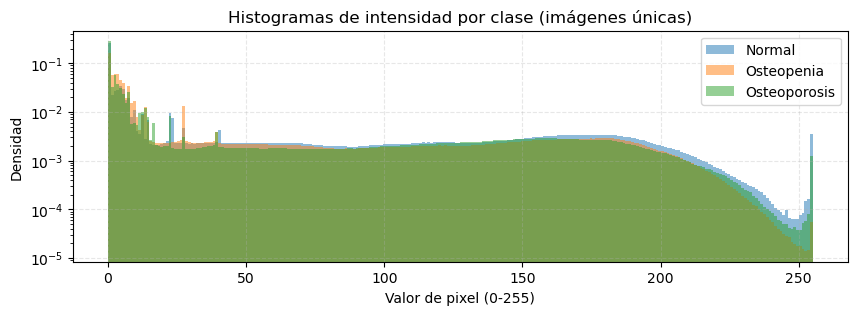

In [41]:
hist_data = defaultdict(list)

# Agrupo los arrays de píxeles por clase desde las imágenes únicas
for clase, img_path in imagenes_unicas:
    try:
        img = Image.open(img_path).convert('RGB')
        arr = np.array(img).flatten()
        hist_data[clase].append(arr)
    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")

# Concatena por clase
for clase in hist_data:
    hist_data[clase] = np.concatenate(hist_data[clase])

# Graficar
plt.figure(figsize=(10, 3))
for clase, datos in hist_data.items():
    plt.hist(datos, bins=256, range=(0, 255), alpha=0.5, label=clase, density=True)

plt.title("Histogramas de intensidad por clase (imágenes únicas)")
plt.xlabel("Valor de pixel (0-255)")
plt.yscale('log')
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

A partir del análisis de los histogramas de intensidad, se observaron diferencias notables entre las distintas clases, especialmente en las regiones de baja intensidad (valores cercanos al negro absoluto). En contraste, las diferencias en las zonas de alta intensidad resultaron mínimas, aunque detectables gracias a la escala logarítmica utilizada en el eje Y. Esta información puede resultar útil para el entrenamiento de modelos de clasificación, ya que sugiere la existencia de patrones específicos en la distribución de intensidades por clase.

A continuación, se analizó la densidad de intensidad de píxeles por grupo, considerando tanto las imágenes originales como aquellas generadas mediante técnicas de data augmentation. Esta información se representó gráficamente mediante histogramas, lo que permitió comparar visualmente las distribuciones y evaluar la coherencia entre los datos sintéticos y los reales.

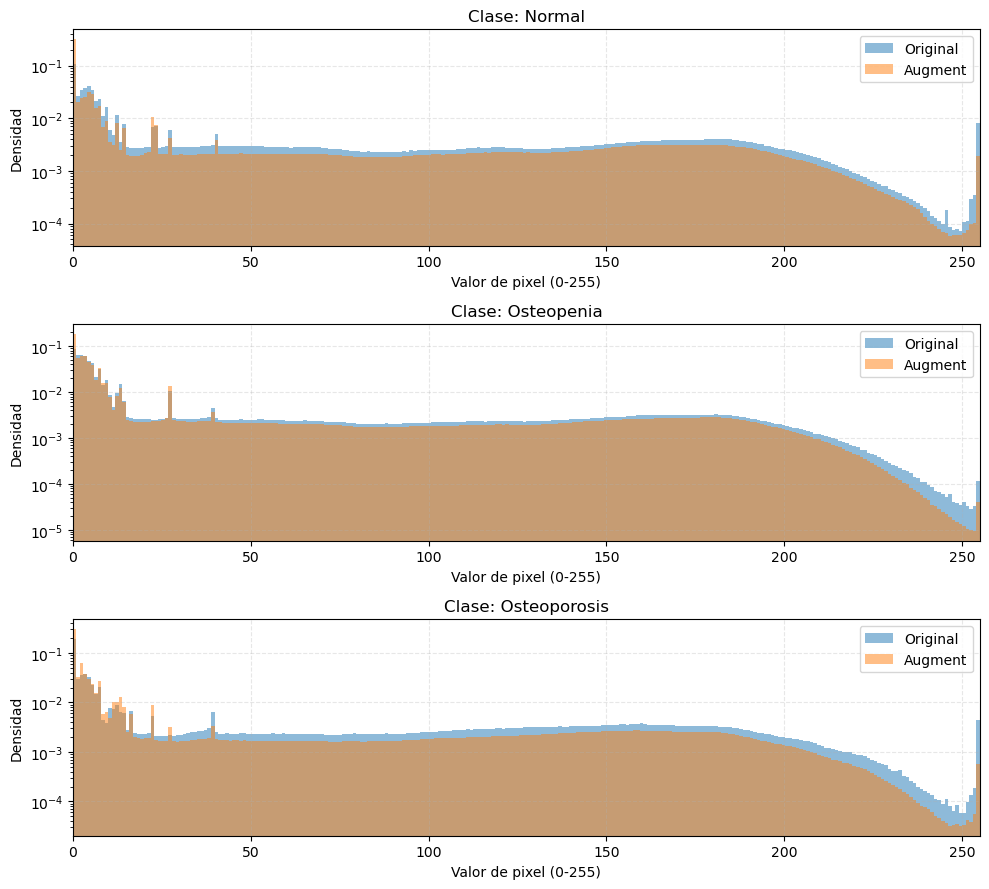

In [42]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))

for i, clase in enumerate(clases):
    originales = []
    augmentadas = []

    for c, img_path in imagenes_unicas:
        if c != clase:
            continue
        try:
            img = Image.open(img_path).convert('RGB')
            arr = np.array(img).flatten()

            if 'aug' in os.path.basename(img_path).lower():
                augmentadas.append(arr)
            else:
                originales.append(arr)
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

    datos_original = np.concatenate(originales) if originales else np.array([])
    datos_aug = np.concatenate(augmentadas) if augmentadas else np.array([])

    if datos_original.size > 0:
        axs[i].hist(datos_original, bins=256, range=(0, 255), alpha=0.5, label='Original', density=True)
    if datos_aug.size > 0:
        axs[i].hist(datos_aug, bins=256, range=(0, 255), alpha=0.5, label='Augment', density=True)

    axs[i].set_title(f"Clase: {clase}")
    axs[i].set_xlim(0, 255)
    axs[i].set_xlabel("Valor de pixel (0-255)")
    axs[i].set_ylabel("Densidad")
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.3)
    axs[i].set_yscale('log')

plt.tight_layout()
plt.show()

El *data augmentation*, en particular la rotación, introduce píxeles negros en las esquinas y puede eliminar regiones con información (píxeles con valores de luminosidad mayores a cero) de las imágenes originales. Por este motivo, se observan diferencias en los histogramas de intensidad entre las imágenes con *data augmentation* y las originales.

La clase con más imágenes con *data augmentation* es **Osteoporosis** (907), seguida de **Osteopenia** (885) y **Normal** (824). Esta diferencia en cantidad y contenido podría influir en el comportamiento del modelo durante el entrenamiento.

## Observaciones

A partir del Exploratory Data Analysis (EDA) realizado, se puede decir:

- **Clases balanceadas**: cada clase tiene la misma cantidad de imágenes.
- **Dimensiones uniformes**: todas las imágenes son de 224x224 píxeles.
- **Formato consistente**: todas las imágenes están en escala de grises.
- **Estadísticas**: las medias y desviaciones estándar de intensidad se solapan entre clases, por lo que no ofrecen información discriminativa clara.
- **Distribución de intensidades**: los histogramas por clase muestran diferencias leves en la distribución de píxeles, lo cual podría ser aprovechado por el modelo durante el entrenamiento.
- **Data augmentation**: se aplican transformaciones de rotación, flips horizontales, escalado y deformaciones (shear). Esto permite que el modelo aprenda a generalizar mejor frente a imágenes nuevas que no vio durante el entrenamiento.

## **3.5 Preparación de datos para el entrenamiento**
---
A continuación, se generaron los tensores necesarios para el entrenamiento de los modelos. Como parte del preprocesamiento, se realizó una estandarización de los datos, calculando el promedio y la desviación estándar a partir de todas las imágenes previamente filtradas. Esta normalización permite que los valores de intensidad estén en una escala común, lo cual facilita el aprendizaje del modelo y mejora su estabilidad durante el entrenamiento.

In [43]:
pixeles = []

for clase, ruta in imagenes_unicas:
    img = Image.open(ruta).convert('RGB')
    arr = np.array(img).astype(np.float32) / 255.0
    pixeles.append(arr.flatten())

pixeles = np.concatenate(pixeles)
mean = pixeles.mean()
std = pixeles.std()

print(f"Media global (únicas): {mean:.4f}")
print(f"Desvío estándar global (únicas): {std:.4f}")

Media global (únicas): 0.2204
Desvío estándar global (únicas): 0.2751


In [44]:
import torch
# Transformación global (la misma para train, val y test)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[mean], std=[std])
])

clase_to_idx = {c: i for i, c in enumerate(clases)}

def procesar_y_guardar_conjunto(nombre_subcarpeta, nombre_archivo_salida, usar_imagenes_unicas=False):
    datos = []
    etiquetas = []

    if usar_imagenes_unicas and nombre_subcarpeta == 'train':
        for clase, img_path in imagenes_unicas:
            img = Image.open(img_path).convert('RGB')
            tensor = transform(img)
            datos.append(tensor)
            etiquetas.append(clase_to_idx[clase])
    else:
        for clase in clases:
            carpeta = f"{path}/Knee Osteoarthritis Classification/{nombre_subcarpeta}/{clase}"
            for nombre in os.listdir(carpeta):
                img = Image.open(f"{carpeta}/{nombre}").convert('RGB')
                tensor = transform(img)
                datos.append(tensor)
                etiquetas.append(clase_to_idx[clase])

    X = torch.stack(datos)
    y = torch.tensor(etiquetas)
    torch.save((X, y), nombre_archivo_salida)
    print(f"{nombre_archivo_salida} guardado: {X.shape[0]} imágenes")

procesar_y_guardar_conjunto('train', 'train_normalizado.pt', usar_imagenes_unicas=True)
procesar_y_guardar_conjunto('val', 'val_normalizado.pt')
procesar_y_guardar_conjunto('test', 'test_normalizado.pt')

train_normalizado.pt guardado: 3330 imágenes
val_normalizado.pt guardado: 1080 imágenes
test_normalizado.pt guardado: 540 imágenes


El modelo puede entrenarse a partir de los archivos **.pt** generados.